In [33]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

In [21]:
root_dir = os.path.join('raw_data')
train_ship_dir = os.path.join(root_dir, 'training_set', 'ship')
train_no_ship_dir = os.path.join(root_dir, 'training_set', 'no-ship')

train_ship_images = os.listdir(train_ship_dir)
train_no_ship_images = os.listdir(train_no_ship_dir)

print(len(train_ship_images))
print(len(train_no_ship_images))

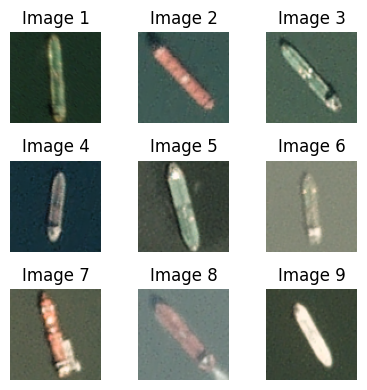

In [20]:
fig, axes = plt.subplots(3, 3, figsize=(4, 4))

for i, ax in enumerate(axes.flat):
    if i < 9:
        img_path = os.path.join(train_ship_dir, train_ship_images[i])
        img = cv2.imread(img_path)

        if img is not None:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(f"Image {i+1}")
        else:
            ax.set_title(f"Image at {img_path} could not be loaded.")
    ax.axis('off')

plt.tight_layout()
plt.show()


`datasets.ImageFolder` expects the root directory to contain subdirectories, where each subdirectory corresponds to a class label. It assigns labels in the order the folders are found (alphabetically). So, `no_ship/` gets the label `0`, and `ship/` gets the label `1`.

# Model

In [40]:
def get_data_loaders(root_dir, batch_size=16, train_val_split=0.9):
    # resize and convert to tensor
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # load data
    dataset = datasets.ImageFolder(root=root_dir, transform=transform)

    # train and val split
    train_size = int(train_val_split * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [41]:
import torch
import torch.nn as nn
from torchvision import models

def initialise_model(num_classes=2):
    model = models.resnet34(pretrained=True)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

In [48]:
import torch
import torch.optim as optim
import torch.nn as nn

def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predict =torch.max(outputs, 1)
            correct += (predict == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        validate_model(model, val_loader, criterion)

    print('Finished training!')


In [49]:
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')